# Segmentation of skin lesions using U-Net CNN architecture

Paulo Roberto DE MOURA JÚNIOR

Based on paper "U-Net: Convolutional Networks for Biomedical Image Segmentation"
https://arxiv.org/abs/1505.04597

Code implementation based on https://towardsdatascience.com/cook-your-first-u-net-in-pytorch-b3297a844cf3

## Training and evaluating the model

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.functional import relu
import torchvision.transforms as transforms
import torchvision
import os
from PIL import Image
from tqdm import tqdm

Versions:
* python: 3.10
* pytorch-cuda: 11.8

In [3]:
print(torch.__version__)
print(torchvision.__version__)

2.3.0
0.18.0


In [4]:
class UNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()
        
        # Encoder
        # In the encoder, convolutional layers with the Conv2d function are used to extract features from the input image. 
        # Each block in the encoder consists of two convolutional layers followed by a max-pooling layer, with the exception of the last block which does not include a max-pooling layer.
        # -------
        # input: 572x572x3
        self.e11 = nn.Conv2d(3, 64, kernel_size=3, padding=1) # output: 570x570x64
        self.e12 = nn.Conv2d(64, 64, kernel_size=3, padding=1) # output: 568x568x64
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 284x284x64

        # input: 284x284x64
        self.e21 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # output: 282x282x128
        self.e22 = nn.Conv2d(128, 128, kernel_size=3, padding=1) # output: 280x280x128
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 140x140x128

        # input: 140x140x128
        self.e31 = nn.Conv2d(128, 256, kernel_size=3, padding=1) # output: 138x138x256
        self.e32 = nn.Conv2d(256, 256, kernel_size=3, padding=1) # output: 136x136x256
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 68x68x256

        # input: 68x68x256
        self.e41 = nn.Conv2d(256, 512, kernel_size=3, padding=1) # output: 66x66x512
        self.e42 = nn.Conv2d(512, 512, kernel_size=3, padding=1) # output: 64x64x512
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 32x32x512

        # input: 32x32x512
        self.e51 = nn.Conv2d(512, 1024, kernel_size=3, padding=1) # output: 30x30x1024
        self.e52 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1) # output: 28x28x1024


        # Decoder
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.d11 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.d12 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.d21 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.d22 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.d31 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.d32 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.d41 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.d42 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        # Output layer
        self.outconv = nn.Conv2d(64, n_class, kernel_size=1)
        
    def forward(self, x):
        # Encoder
        xe11 = relu(self.e11(x))
        xe12 = relu(self.e12(xe11))
        xp1 = self.pool1(xe12)

        xe21 = relu(self.e21(xp1))
        xe22 = relu(self.e22(xe21))
        xp2 = self.pool2(xe22)

        xe31 = relu(self.e31(xp2))
        xe32 = relu(self.e32(xe31))
        xp3 = self.pool3(xe32)

        xe41 = relu(self.e41(xp3))
        xe42 = relu(self.e42(xe41))
        xp4 = self.pool4(xe42)

        xe51 = relu(self.e51(xp4))
        xe52 = relu(self.e52(xe51))
        
        # Decoder
        xu1 = self.upconv1(xe52)
        xu11 = torch.cat([xu1, xe42], dim=1)
        xd11 = relu(self.d11(xu11))
        xd12 = relu(self.d12(xd11))

        xu2 = self.upconv2(xd12)
        xu22 = torch.cat([xu2, xe32], dim=1)
        xd21 = relu(self.d21(xu22))
        xd22 = relu(self.d22(xd21))

        xu3 = self.upconv3(xd22)
        xu33 = torch.cat([xu3, xe22], dim=1)
        xd31 = relu(self.d31(xu33))
        xd32 = relu(self.d32(xd31))

        xu4 = self.upconv4(xd32)
        xu44 = torch.cat([xu4, xe12], dim=1)
        xd41 = relu(self.d41(xu44))
        xd42 = relu(self.d42(xd41))

        # Output layer
        out = self.outconv(xd42)

        return out

In [5]:
class TrainDataSet(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.file_names = self.get_file_names()
        
    def get_file_names(self):
        file_names = []
        for file in os.listdir(self.root):
            if file.endswith(".jpg"):
                img_name = os.path.splitext(file)[0]
                seg_name = img_name + "_seg.png"
                if os.path.exists(os.path.join(self.root, seg_name)): #check if there's a mask
                    file_names.append(img_name)
        return file_names

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, index):
        image_filename = self.file_names[index]
        
        image = Image.open(
            os.path.join(self.root, image_filename + ".jpg"), formats=["JPEG"]
        ).convert("RGB")
        
        mask = Image.open(
            os.path.join(self.root, image_filename + "_seg.png"), formats=["PNG"]
        )

        if self.transform:
            # same transform for images and masks
            image = self.transform(image)
            mask = self.transform(mask)
            mask = (mask > 0.5).float()
        return image, mask

In [6]:
# Create datasets for train and validation
train_root = 'train_seg_data'
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

train_data = TrainDataSet(train_root, transform=transform)
print(train_data.__len__())

# separate into train (80%) and validation (20%)
train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_data, [train_size, val_size], generator=torch.Generator().manual_seed(0))


2593


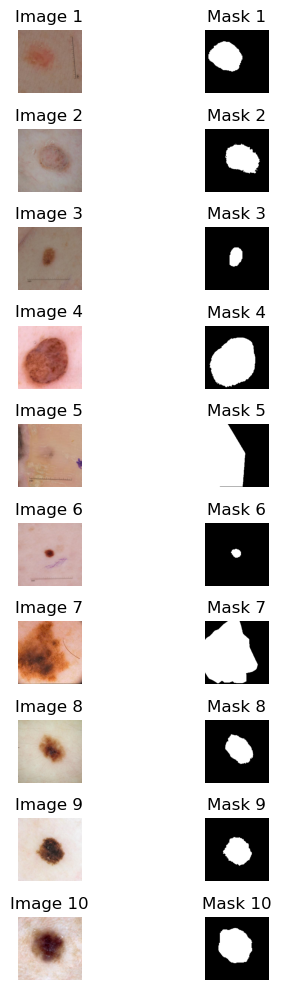

In [7]:
visualize_loader = DataLoader(train_dataset, batch_size=10, shuffle=True, generator=torch.Generator().manual_seed(0), num_workers=4)

for batch_idx, (images, masks) in enumerate(visualize_loader):
    # Convert tensors to NumPy arrays and adjust data type
    images = images.cpu().numpy()  # Shape: (batch_size, C, H, W)
    masks = masks.cpu().numpy()    # Shape: (batch_size, 1, H, W)

    # Convert image and mask values to [0, 255] uint8 range
    images = (images * 255).astype(np.uint8)
    masks = (masks * 255).astype(np.uint8)

    # Plot images and masks side by side in pairs
    num_images = images.shape[0]

    fig, axes = plt.subplots(num_images, 2, figsize=(5, 1 * num_images))

    for i in range(num_images):
        img_np = images[i].transpose(1, 2, 0)  # (C, H, W) to (H, W, C)
        mask_np = masks[i].squeeze()          # Remove single-dimensional entries

        # Display image
        axes[i, 0].imshow(img_np)
        axes[i, 0].set_title(f'Image {i+1}')
        axes[i, 0].axis('off')

        # Display mask
        axes[i, 1].imshow(mask_np, cmap='gray')
        axes[i, 1].set_title(f'Mask {i+1}')
        axes[i, 1].axis('off')

    plt.tight_layout()  # Adjust subplot layout
    plt.show()

    break  # Break after displaying one batch (remove this to visualize all batches)

In [8]:
# check GPU to work
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()
print(device)

cuda


In [9]:
def dice_score(pred, target, threshold=0.5, smooth=1e-8):
    pred = (pred > threshold).float()  # Apply threshold to sigmoid predictions

    # Flatten predictions and targets along batch dimension
    pred_flat = pred.view(pred.size(0), -1)
    target_flat = target.view(target.size(0), -1)

    # Compute intersection and union over the batch
    intersection = torch.sum(pred_flat * target_flat, dim=1)
    union = torch.sum(pred_flat, dim=1) + torch.sum(target_flat, dim=1)

    # Compute Dice score for each sample in the batch
    dice_scores = (2.0 * intersection + smooth) / (union + smooth)

    # Average Dice score over the batch
    avg_dice = torch.mean(dice_scores)

    return avg_dice.item()

In [9]:
# Train model
num_classes = 1
batch_size = 32
num_epochs = 25
learning_rate = 0.0001

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=torch.Generator().manual_seed(0), num_workers=os.cpu_count())
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=os.cpu_count())

model = UNet(n_class=num_classes).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)

train_losses = []
val_losses = []
train_dice_scores = []
val_dice_scores = []

best_val_dice = 0.0  # Initialize best validation DICE score

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    epoch_train_loss = 0.0
    epoch_train_dice = 0.0

    # Training phase with tqdm progress bar
    with tqdm(train_loader, desc=f'Train Epoch {epoch + 1}/{num_epochs}', unit='batch') as train_tqdm:
        for images, masks in train_tqdm:
            images = images.to(device)
            masks = masks.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            train_loss = criterion(outputs, masks)
            train_loss.backward()
            optimizer.step()
            epoch_train_loss += train_loss.item()

            # Calculate DICE score
            dice = dice_score(torch.sigmoid(outputs), masks)
            epoch_train_dice += dice

            train_tqdm.set_postfix({'train_loss': train_loss.item(), 'train_dice': dice})
    
    # Calculate average training loss and DICE score for the epoch
    avg_train_loss = epoch_train_loss / len(train_loader)
    avg_train_dice = epoch_train_dice / len(train_loader)
    train_losses.append(avg_train_loss)
    train_dice_scores.append(avg_train_dice)

    # Validation phase
    model.eval()  # Set model to evaluation mode
    epoch_val_loss = 0.0
    epoch_val_dice = 0.0

    # Disable gradients during validation
    with torch.no_grad():
        for val_images, val_masks in val_loader:
            val_images = val_images.to(device)
            val_masks = val_masks.to(device)
            val_outputs = model(val_images)
            val_loss = criterion(val_outputs, val_masks)
            epoch_val_loss += val_loss.item()

            # Calculate DICE score
            dice = dice_score(torch.sigmoid(val_outputs), val_masks)
            epoch_val_dice += dice
            
    # Calculate average validation loss and DICE score for the epoch
    avg_val_loss = epoch_val_loss / len(val_loader)
    avg_val_dice = epoch_val_dice / len(val_loader)
    val_losses.append(avg_val_loss)
    val_dice_scores.append(avg_val_dice)
    
    # Update the scheduler according to validation loss
    scheduler.step(avg_val_loss)

    # Display training and validation loss, DICE score for the epoch
    current_lr = optimizer.param_groups[0]['lr']  # Get current learning rate
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train DICE: {avg_train_dice:.4f}, Val Loss: {avg_val_loss:.4f}, Val DICE: {avg_val_dice:.4f}, LR: {current_lr}')
    # Check if current validation DICE score is better than the best so far
    if avg_val_dice > best_val_dice:
        best_val_dice = avg_val_dice
        # Save the model checkpoint with the best validation DICE score
        torch.save(model, 'segmentation_unet.pth')

Train Epoch 1/25: 100%|██████████| 65/65 [00:51<00:00,  1.26batch/s, train_loss=0.531, train_dice=0.0886]  


Epoch [1/25], Train Loss: 0.5778, Train DICE: 0.0556, Val Loss: 0.5017, Val DICE: 0.1376, LR: 0.0001


Train Epoch 2/25: 100%|██████████| 65/65 [00:49<00:00,  1.32batch/s, train_loss=0.524, train_dice=0.55] 


Epoch [2/25], Train Loss: 0.4708, Train DICE: 0.4786, Val Loss: 0.4575, Val DICE: 0.4673, LR: 0.0001


Train Epoch 3/25: 100%|██████████| 65/65 [00:49<00:00,  1.31batch/s, train_loss=0.454, train_dice=0.612]


Epoch [3/25], Train Loss: 0.4377, Train DICE: 0.5948, Val Loss: 0.3906, Val DICE: 0.6302, LR: 0.0001


Train Epoch 4/25: 100%|██████████| 65/65 [00:49<00:00,  1.31batch/s, train_loss=0.337, train_dice=0.728]   


Epoch [4/25], Train Loss: 0.3936, Train DICE: 0.6462, Val Loss: 0.4217, Val DICE: 0.5820, LR: 0.0001


Train Epoch 5/25: 100%|██████████| 65/65 [00:49<00:00,  1.31batch/s, train_loss=0.358, train_dice=0.782]


Epoch [5/25], Train Loss: 0.3612, Train DICE: 0.7077, Val Loss: 0.3153, Val DICE: 0.7463, LR: 0.0001


Train Epoch 6/25: 100%|██████████| 65/65 [00:49<00:00,  1.31batch/s, train_loss=0.278, train_dice=0.818]


Epoch [6/25], Train Loss: 0.3210, Train DICE: 0.7549, Val Loss: 0.2832, Val DICE: 0.7659, LR: 0.0001


Train Epoch 7/25: 100%|██████████| 65/65 [00:50<00:00,  1.29batch/s, train_loss=0.357, train_dice=0.793]


Epoch [7/25], Train Loss: 0.2990, Train DICE: 0.7662, Val Loss: 0.3078, Val DICE: 0.7472, LR: 0.0001


Train Epoch 8/25: 100%|██████████| 65/65 [00:49<00:00,  1.31batch/s, train_loss=0.272, train_dice=0.811]


Epoch [8/25], Train Loss: 0.2731, Train DICE: 0.7855, Val Loss: 0.2835, Val DICE: 0.7665, LR: 0.0001


Train Epoch 9/25: 100%|██████████| 65/65 [00:50<00:00,  1.29batch/s, train_loss=0.242, train_dice=0.833]


Epoch [9/25], Train Loss: 0.2595, Train DICE: 0.7925, Val Loss: 0.2496, Val DICE: 0.7859, LR: 0.0001


Train Epoch 10/25: 100%|██████████| 65/65 [00:50<00:00,  1.29batch/s, train_loss=0.215, train_dice=0.792]


Epoch [10/25], Train Loss: 0.2402, Train DICE: 0.8040, Val Loss: 0.2889, Val DICE: 0.7693, LR: 0.0001


Train Epoch 11/25: 100%|██████████| 65/65 [00:50<00:00,  1.29batch/s, train_loss=0.177, train_dice=0.813]


Epoch [11/25], Train Loss: 0.2247, Train DICE: 0.8165, Val Loss: 0.2129, Val DICE: 0.8174, LR: 0.0001


Train Epoch 12/25: 100%|██████████| 65/65 [00:49<00:00,  1.31batch/s, train_loss=0.165, train_dice=0.781]


Epoch [12/25], Train Loss: 0.2118, Train DICE: 0.8235, Val Loss: 0.2014, Val DICE: 0.8253, LR: 0.0001


Train Epoch 13/25: 100%|██████████| 65/65 [00:53<00:00,  1.22batch/s, train_loss=0.17, train_dice=0.843] 


Epoch [13/25], Train Loss: 0.2018, Train DICE: 0.8310, Val Loss: 0.2027, Val DICE: 0.8215, LR: 0.0001


Train Epoch 14/25: 100%|██████████| 65/65 [01:02<00:00,  1.03batch/s, train_loss=0.246, train_dice=0.825]


Epoch [14/25], Train Loss: 0.2080, Train DICE: 0.8240, Val Loss: 0.2120, Val DICE: 0.8109, LR: 0.0001


Train Epoch 15/25: 100%|██████████| 65/65 [00:58<00:00,  1.11batch/s, train_loss=0.176, train_dice=0.857] 


Epoch [15/25], Train Loss: 0.1990, Train DICE: 0.8331, Val Loss: 0.2030, Val DICE: 0.8274, LR: 1e-05


Train Epoch 16/25: 100%|██████████| 65/65 [00:58<00:00,  1.11batch/s, train_loss=0.139, train_dice=0.872] 


Epoch [16/25], Train Loss: 0.1765, Train DICE: 0.8480, Val Loss: 0.1861, Val DICE: 0.8349, LR: 1e-05


Train Epoch 17/25: 100%|██████████| 65/65 [00:57<00:00,  1.13batch/s, train_loss=0.169, train_dice=0.845] 


Epoch [17/25], Train Loss: 0.1716, Train DICE: 0.8486, Val Loss: 0.1858, Val DICE: 0.8357, LR: 1e-05


Train Epoch 18/25: 100%|██████████| 65/65 [00:59<00:00,  1.09batch/s, train_loss=0.139, train_dice=0.848] 


Epoch [18/25], Train Loss: 0.1707, Train DICE: 0.8490, Val Loss: 0.1836, Val DICE: 0.8367, LR: 1e-05


Train Epoch 19/25: 100%|██████████| 65/65 [00:59<00:00,  1.09batch/s, train_loss=0.177, train_dice=0.833]


Epoch [19/25], Train Loss: 0.1679, Train DICE: 0.8497, Val Loss: 0.1849, Val DICE: 0.8333, LR: 1e-05


Train Epoch 20/25: 100%|██████████| 65/65 [00:58<00:00,  1.11batch/s, train_loss=0.209, train_dice=0.845]


Epoch [20/25], Train Loss: 0.1681, Train DICE: 0.8503, Val Loss: 0.1848, Val DICE: 0.8324, LR: 1e-05


Train Epoch 21/25: 100%|██████████| 65/65 [00:50<00:00,  1.29batch/s, train_loss=0.154, train_dice=0.832] 


Epoch [21/25], Train Loss: 0.1666, Train DICE: 0.8505, Val Loss: 0.1813, Val DICE: 0.8342, LR: 1e-05


Train Epoch 22/25: 100%|██████████| 65/65 [00:52<00:00,  1.23batch/s, train_loss=0.153, train_dice=0.849]


Epoch [22/25], Train Loss: 0.1654, Train DICE: 0.8506, Val Loss: 0.1824, Val DICE: 0.8348, LR: 1e-05


Train Epoch 23/25: 100%|██████████| 65/65 [00:53<00:00,  1.21batch/s, train_loss=0.143, train_dice=0.9]   


Epoch [23/25], Train Loss: 0.1649, Train DICE: 0.8517, Val Loss: 0.1807, Val DICE: 0.8356, LR: 1e-05


Train Epoch 24/25: 100%|██████████| 65/65 [00:52<00:00,  1.23batch/s, train_loss=0.178, train_dice=0.877] 


Epoch [24/25], Train Loss: 0.1643, Train DICE: 0.8517, Val Loss: 0.1818, Val DICE: 0.8350, LR: 1e-05


Train Epoch 25/25: 100%|██████████| 65/65 [00:54<00:00,  1.20batch/s, train_loss=0.103, train_dice=0.881] 


Epoch [25/25], Train Loss: 0.1628, Train DICE: 0.8537, Val Loss: 0.1805, Val DICE: 0.8383, LR: 1e-05


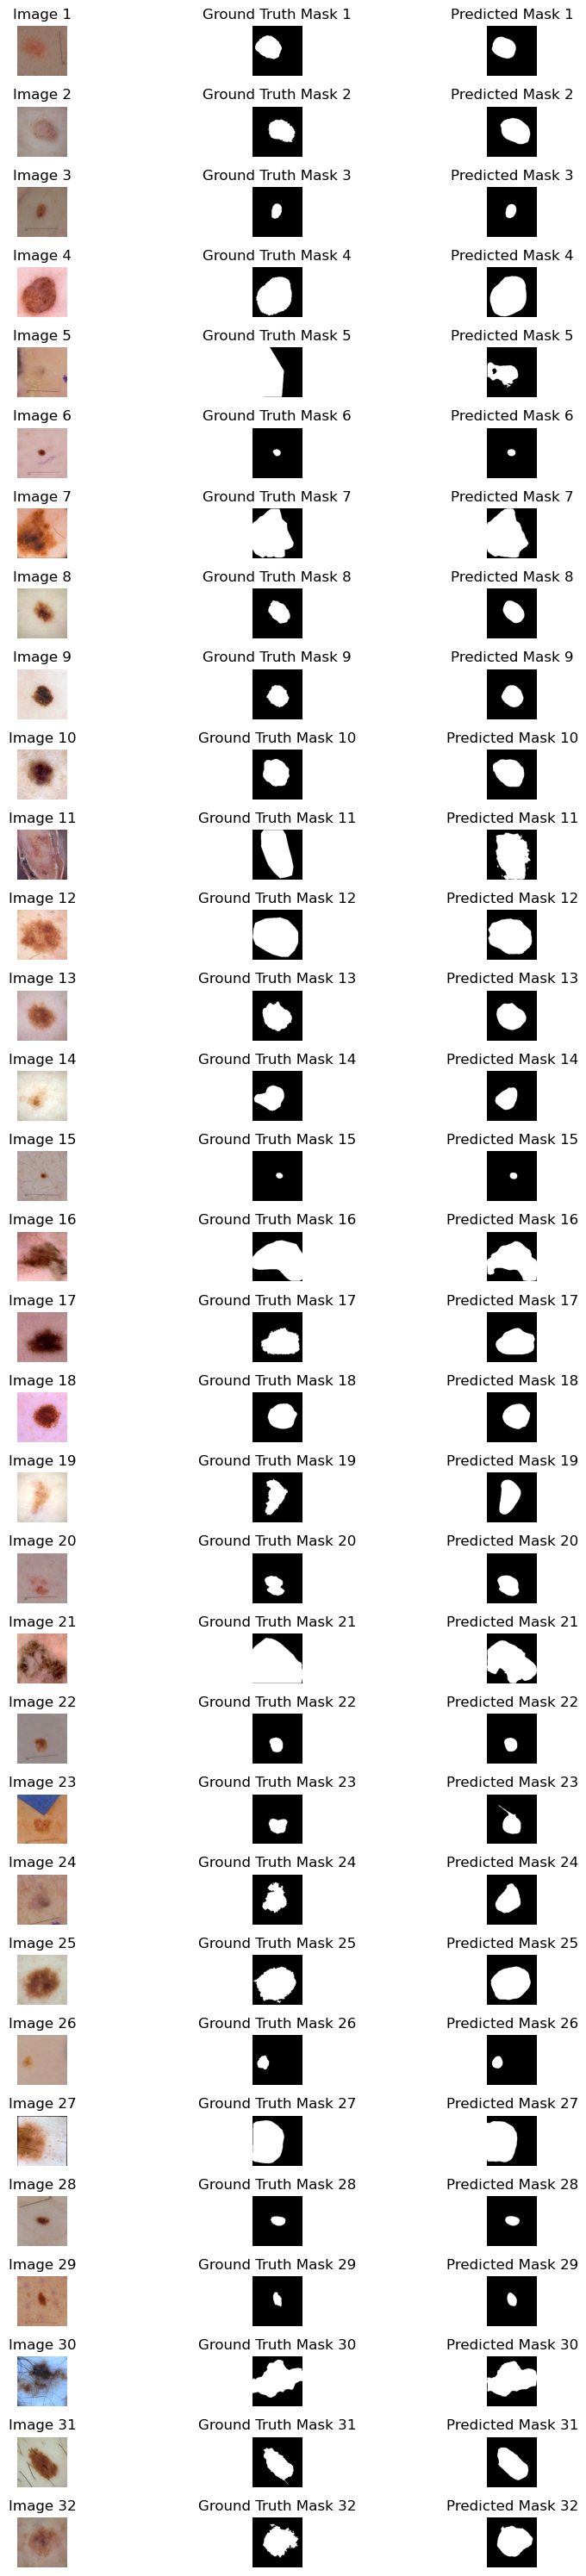

In [22]:
# plotting some training results to visual inspection
model.eval()
threshold = 0.5

# Get a batch of training samples
images, masks = next(iter(train_loader))

# Move the images and masks to the device
images = images.to(device)
masks = masks.to(device)

# Generate the predicted masks
with torch.no_grad():
    outputs = model(images).squeeze()
    predicted_masks = torch.sigmoid(outputs)

# Convert the tensors to numpy arrays
images_np = images.cpu().numpy()
masks_np = masks.cpu().numpy()*255
predicted_masks_np = ((predicted_masks.cpu().numpy() > threshold)*255).astype(np.uint8)

# Plot the images, ground truth masks, and predicted masks
fig, axes = plt.subplots(len(images), 3, figsize=(10, 30))

for i in range(len(images)):
    axes[i, 0].imshow(images_np[i].transpose(1, 2, 0))
    axes[i, 0].set_title('Image {}'.format(i+1))
    axes[i, 0].axis('off')

    axes[i, 1].imshow(masks_np[i].transpose(1, 2, 0), cmap='gray')
    axes[i, 1].set_title('Ground Truth Mask {}'.format(i+1))
    axes[i, 1].axis('off')

    axes[i, 2].imshow(predicted_masks_np[i], cmap='gray')
    axes[i, 2].set_title('Predicted Mask {}'.format(i+1))
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()

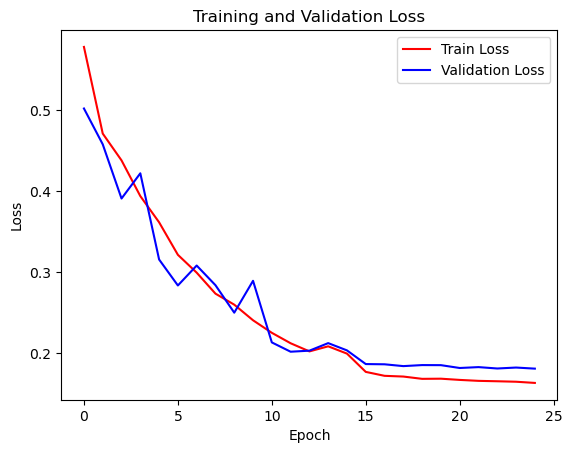

In [11]:
plt.title('Training and Validation Loss')
plt.plot(train_losses, label='Train Loss', color='r')
plt.plot(val_losses, label='Validation Loss', color='b')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

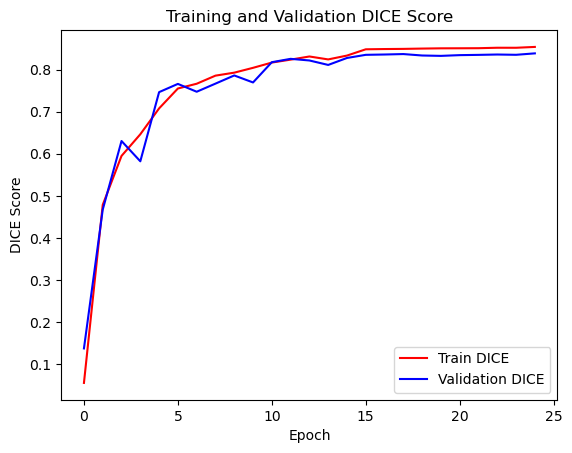

In [12]:
plt.title('Training and Validation DICE Score')
plt.plot(train_dice_scores, label='Train DICE', color='r')
plt.plot(val_dice_scores, label='Validation DICE', color='b')
plt.xlabel('Epoch')
plt.ylabel('DICE Score')
plt.legend()
plt.show()

Evaluating final model dice 

In [10]:
# Loading model 

# Define the device to use ('cuda' if available, otherwise 'cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Path to the saved model checkpoint
checkpoint_path = 'segmentation_unet.pth'

# Load the entire model checkpoint
model = torch.load(checkpoint_path, map_location=device)

# Ensure that the loaded model is an instance of your UNet class
if not isinstance(model, UNet):
    raise TypeError("The loaded model is not an instance of the expected UNet class.")

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=torch.Generator().manual_seed(0), num_workers=os.cpu_count())
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=os.cpu_count())

In [11]:
def dice_coefficient(mask1, mask2):
    intersection = np.logical_and(mask1, mask2)
    dice = (2 * np.sum(intersection)) / (np.sum(mask1) + np.sum(mask2) + 1e-12)
    return dice

In [14]:
model.eval()
threshold = 0.5

true_masks = []
pred_masks = []
dice_torch = 0

for images, masks in val_loader:
    # Move the images and masks to the device
    images = images.to(device)
    masks = masks.to(device)

    # Generate the predicted masks
    with torch.no_grad():
        outputs = model(images).squeeze()
        predicted_masks = torch.sigmoid(outputs)
    
    # Convert the tensors to numpy arrays
    masks_np = masks.cpu().numpy().squeeze()
    predicted_masks_np = (predicted_masks.cpu().numpy() > threshold).astype(np.uint8)
    
    true_masks.extend(masks_np)
    pred_masks.extend(predicted_masks_np)

dice = []
for i in range(len(true_masks)):
    true_mask = true_masks[i]
    pred_mask = pred_masks[i]

    # Calculate the DICE coefficient
    dice_score = dice_coefficient(true_mask, pred_mask)
    dice.append(dice_score)

# Calculate the average DICE coefficient
average_dice = np.mean(dice)
print(f'Average DICE: {average_dice:.4f}')
print(f'Standard Deviation of DICE: {np.std(dice, ddof=1):.4f}')

Average DICE: 0.8736
Standard Deviation of DICE: 0.1312


## Generating missing masks and resizing images

Generating missing masks for train and test, resizing original images and separating into different folders

In [8]:
class SegmentDataSet(Dataset): #dataset for segmenting images without masks
    def __init__(self, root, only_img_proc = False, transform=None):
        self.root = root
        self.transform = transform
        self.img_processing_only = only_img_proc
        self.file_names = self.get_file_names()
        
    def get_file_names(self):
        file_names = []
        for file in os.listdir(self.root):
            if file.endswith(".jpg"):
                img_name = os.path.splitext(file)[0]
                seg_name = img_name + "_seg.png"
                if self.img_processing_only == True:
                    if os.path.exists(os.path.join(self.root, seg_name)): #check if there's a mask
                        file_names.append(img_name)
                else:
                    if not os.path.exists(os.path.join(self.root, seg_name)): #check if there's no mask
                        file_names.append(img_name)
        return file_names

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, index):
        if self.img_processing_only == True:
            image_filename = self.file_names[index]
            
            image = Image.open(
                os.path.join(self.root, image_filename + ".jpg"), formats=["JPEG"]
            ).convert("RGB")
            
            mask = Image.open(
                os.path.join(self.root, image_filename + "_seg.png"), formats=["PNG"]
            )
            if self.transform:
                # same transform for images and masks
                image = self.transform(image)
                mask = self.transform(mask)
                
            return image, mask, image_filename
        else:
            image_filename = self.file_names[index]
            image = Image.open(
                os.path.join(self.root, image_filename + ".jpg"), formats=["JPEG"]
            ).convert("RGB")

            if self.transform:
                image = self.transform(image)
                
            return image, image_filename

In [10]:
train_folder = 'Train'
test_folder = 'Test'
folder_train_masks = 'Train_masks'
folder_test_masks = 'Test_masks'
folder_train_imgs = 'Train_imgs'
folder_test_imgs = 'Test_imgs'

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

train_images = SegmentDataSet(train_folder, transform=transform)
test_images = SegmentDataSet(test_folder, transform=transform)
train_loader = DataLoader(train_images, batch_size=32, shuffle=False, num_workers=os.cpu_count())
test_loader = DataLoader(test_images, batch_size=32, shuffle=False, num_workers=os.cpu_count())

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
checkpoint_path = 'segmentation_unet.pth'
model = torch.load(checkpoint_path, map_location=device)

model.eval()
threshold = 0.5

# Generate missing masks for train images, save resized images and masks
print('Generating missing masks for train images...')
for images, image_filenames in train_loader:
    images = images.to(device)
    with torch.no_grad():
        outputs = model(images).squeeze()
        predicted_masks = torch.sigmoid(outputs)
    
    images_np = images.cpu().numpy()
    predicted_masks_np = ((predicted_masks.cpu().numpy() > threshold)*255).astype(np.uint8)
    
    for i in range(len(predicted_masks_np)):
        image = (images_np[i].transpose(1, 2, 0)*255).astype(np.uint8)
        predicted_mask = predicted_masks_np[i]
        image = Image.fromarray(image)
        predicted_mask = Image.fromarray(predicted_mask)
        image.save(os.path.join(folder_train_imgs, image_filenames[i] + '.jpg'))
        predicted_mask.save(os.path.join(folder_train_masks, image_filenames[i] + '_seg.png'))

# Generate missing masks for test images, save resized images and masks
print('Generating missing masks for test images...')
for images, image_filenames in test_loader:
    images = images.to(device)
    with torch.no_grad():
        outputs = model(images).squeeze()
        predicted_masks = torch.sigmoid(outputs)
    
    images_np = images.cpu().numpy()
    predicted_masks_np = ((predicted_masks.cpu().numpy() > threshold)*255).astype(np.uint8)
    
    for i in range(len(predicted_masks_np)):
        image = (images_np[i].transpose(1, 2, 0)*255).astype(np.uint8)
        predicted_mask = predicted_masks_np[i]
        image = Image.fromarray(image)
        predicted_mask = Image.fromarray(predicted_mask)
        image.save(os.path.join(folder_test_imgs, image_filenames[i] + '.jpg'))
        predicted_mask.save(os.path.join(folder_test_masks, image_filenames[i] + '_seg.png'))

# Resizing and saving existing images and masks in train and test
train_images = SegmentDataSet(train_folder, only_img_proc=True, transform=transform)
test_images = SegmentDataSet(test_folder, only_img_proc=True, transform=transform)
train_loader = DataLoader(train_images, batch_size=32, shuffle=False, num_workers=os.cpu_count())
test_loader = DataLoader(test_images, batch_size=32, shuffle=False, num_workers=os.cpu_count())

# train
print('Resizing and saving existing images and masks in train...')
for images, masks, image_filenames in train_loader:
    for i in range(len(images)):
        image = (images[i].cpu().numpy().transpose(1, 2, 0)*255).astype(np.uint8)
        mask = (masks[i].cpu().numpy().squeeze()*255).astype(np.uint8)
        image = Image.fromarray(image)
        mask = Image.fromarray(mask)
        image.save(os.path.join(folder_train_imgs, image_filenames[i] + '.jpg'))
        mask.save(os.path.join(folder_train_masks, image_filenames[i] + '_seg.png'))
    break

# test
print('Resizing and saving existing images and masks in test...')
for images, masks, image_filenames in test_loader:
    for i in range(len(images)):
        image = (images[i].cpu().numpy().transpose(1, 2, 0)*255).astype(np.uint8)
        mask = (masks[i].cpu().numpy().squeeze()*255).astype(np.uint8)
        image = Image.fromarray(image)
        mask = Image.fromarray(mask)
        image.save(os.path.join(folder_test_imgs, image_filenames[i] + '.jpg'))
        mask.save(os.path.join(folder_test_masks, image_filenames[i] + '_seg.png'))
    break

cuda
Generating missing masks for train images...
Generating missing masks for test images...
Resizing and saving existing images and masks in train...
Resizing and saving existing images and masks in test...
